# Denoising (DAE)

## Introduction

## 0. Imports & variables

In [1]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import image_dataset_from_directory
import pandas as pd
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
training_folder = './processed_data/photos/'
noisy_folder = './sducesinoisy/'
test_folder = "./OneDrive_2022-09-22/Dataset Livrable 2/Dataset/"

## 1. Création d'images bruitées
### Chargement des images

In [4]:
def load_images_from_folder(folder_path):
    images = []
    for filename in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append((filename, img))
    return images

original_images = load_images_from_folder(training_folder)

  0%|          | 0/29979 [00:00<?, ?it/s]

### Ajout de bruit et sauvegarde

In [26]:
def clear_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

def add_random_noise_to_images(images, noisy_folder, mean=0, sigma=25, salt_pepper_ratio=0.02, speckle_sigma=0.1):
    clear_folder(noisy_folder)
    noise_types = ['gaussian', 'salt_pepper', 'speckle']

    for filename, img in tqdm(images):
        row, col, ch = img.shape
        noisy = img.astype(np.float32)  # Convertir en float pour les opérations de bruit

        # Sélectionner un nombre aléatoire de types de bruits à appliquer
        num_noises_to_apply = random.randint(1, len(noise_types))
        noises_to_apply = random.sample(noise_types, num_noises_to_apply)

        for noise_type in noises_to_apply:
            if noise_type == 'gaussian':
                gauss = np.random.normal(mean, sigma, (row, col, ch))
                noisy += gauss

            elif noise_type == 'salt_pepper':
                # Calcul du nombre de pixels "sel" et "poivre"
                num_salt = np.ceil(salt_pepper_ratio * noisy.size * 0.5)
                num_pepper = num_salt

                # Ajout du bruit "sel"
                salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in [row, col]]
                noisy[salt_coords[0], salt_coords[1], :] = 255

                # Ajout du bruit "poivre"
                pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in [row, col]]
                noisy[pepper_coords[0], pepper_coords[1], :] = 0

            elif noise_type == 'speckle':
                gauss = np.random.randn(row, col, ch)
                noisy += noisy * gauss * speckle_sigma

        noisy = np.clip(noisy, 0, 255).astype(np.uint8)  # Clip après tous les ajouts de bruit
        noisy_filename = "noisy_" + filename
        cv2.imwrite(os.path.join(noisy_folder, noisy_filename), noisy)

add_random_noise_to_images(original_images, noisy_folder)

  0%|          | 0/29979 [00:00<?, ?it/s]

## 2. Chargement des données originales et bruitées

In [4]:
def load_and_normalize_from_directory(directory, batch_size=64, img_size=(304, 304), validation_split=None, subset=None):
    dataset = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode=None,  # Aucun label car nous construisons un autoencoder
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=123,
        validation_split=validation_split,
        subset=subset
    )
    
    dataset = dataset.map(lambda x: x / 255.0, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [5]:
originals_train = load_and_normalize_from_directory(training_folder, validation_split=0.1, subset='training')
originals_val = load_and_normalize_from_directory(training_folder, validation_split=0.1, subset='validation')
noisies_train = load_and_normalize_from_directory(noisy_folder, validation_split=0.1, subset='training')
noisies_val = load_and_normalize_from_directory(noisy_folder, validation_split=0.1, subset='validation')

Found 29979 files belonging to 1 classes.
Using 26982 files for training.
Found 29979 files belonging to 1 classes.
Using 2997 files for validation.
Found 29979 files belonging to 1 classes.
Using 26982 files for training.
Found 29979 files belonging to 1 classes.
Using 2997 files for validation.


In [6]:
def combine_datasets(dataset1, dataset2):
    combined_dataset = tf.data.Dataset.zip((dataset1, dataset2))
    return combined_dataset

train_dataset = combine_datasets(noisies_train, originals_train)
val_dataset = combine_datasets(noisies_val, originals_val)

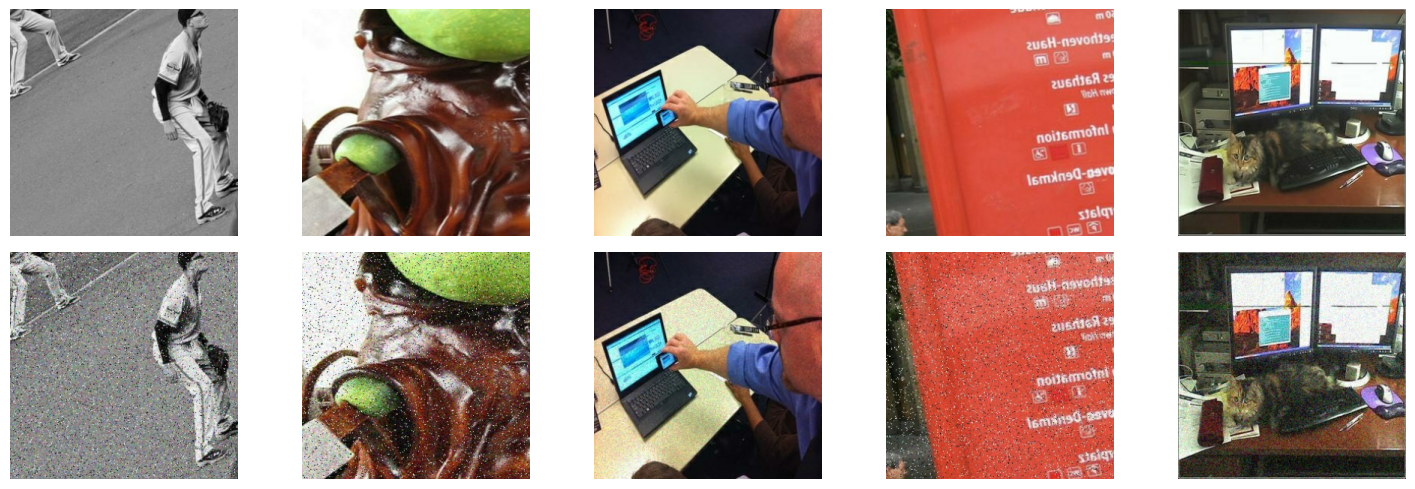

In [7]:
def display_pairs(train_dataset, num_samples=5):
    # Prendre les num_samples premiers batches du dataset
    samples = list(train_dataset.take(num_samples))
    
    # Extraire la première image de chaque batch pour l'affichage
    noisies_samples = [pair[0][0].numpy() for pair in samples]
    originals_samples = [pair[1][0].numpy() for pair in samples]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[0, i].imshow(originals_samples[i])
        axes[1, i].imshow(noisies_samples[i])
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

display_pairs(train_dataset)

## 3. Création du modèle

In [8]:
dae = None
with tf.device('/GPU:0'):
    input_shape = (304, 304, 3)

    encoder = Sequential()
    encoder.add(Input(shape=input_shape))
    encoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))  
    encoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))  
    encoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))   
    
    decoder = Sequential()
    decoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  
    #Tester averagePooling et Nrelu
    
    dae = Sequential([encoder, decoder])
    dae.compile(optimizer='adam', loss='binary_crossentropy')
    dae.build((None, 304, 304, 3))
    encoder.summary()
    decoder.summary()
    dae.summary()
    
#Expliquer pourquoi on utilise cette LOSS

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 152, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 152, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 76, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 38, 128)      0

## 4. Entraînement du modèle

In [36]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/dae/" + date
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
#tensorboard --logdir logs/fit/dae --bind_all

model_checkpoint_directory = f"weights/dae/{date}/"
os.makedirs(model_checkpoint_directory, exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_checkpoint_directory}{{epoch:02d}}-{{val_loss:.4f}}.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=False)

with tf.device('/GPU:0'):
    dae.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/15
422/422 [==============================] - 221s 479ms/step - loss: 0.5290 - val_loss: 0.5135
Epoch 2/15
422/422 [==============================] - 194s 458ms/step - loss: 0.5168 - val_loss: 0.5118
Epoch 3/15
422/422 [==============================] - 193s 457ms/step - loss: 0.5154 - val_loss: 0.5104
Epoch 4/15
422/422 [==============================] - 194s 457ms/step - loss: 0.5145 - val_loss: 0.5095
Epoch 5/15
422/422 [==============================] - 193s 456ms/step - loss: 0.5138 - val_loss: 0.5103
Epoch 6/15
422/422 [==============================] - 194s 458ms/step - loss: 0.5135 - val_loss: 0.5092
Epoch 7/15
422/422 [==============================] - 194s 459ms/step - loss: 0.5130 - val_loss: 0.5082
Epoch 8/15
422/422 [==============================] - 194s 458ms/step - loss: 0.5127 - val_loss: 0.5084
Epoch 9/15
422/422 [==============================] - 194s 458ms/step - loss: 0.5124 - val_loss: 0.5079
Epoch 10/15
422/422 [==============================] - 194s 458m

In [9]:
dae.load_weights("./weights/dae/20231013-115113/14-0.5072.h5")

## 5. Evaluation du modèle
### 5.1. Evaluation sur le jeu de test

In [10]:
def evaluate_model(model, test_dataset):
    loss = model.evaluate(test_dataset)
    print(f"Model Loss: {loss}")
evaluate_model(dae, val_dataset)

47/47 [==============================] - 16s 207ms/step - loss: 0.5072
Model Loss: 0.507204532623291


In [11]:
def calculate_metrics(original, reconstructed):
    data_range = 1.0  # puisque vos images sont normalisées dans la plage [0, 1]
    psnr_val = psnr(original, reconstructed, data_range=data_range)
    ssim_val = ssim(original, reconstructed, multichannel=True, data_range=data_range, win_size=min(7, min(original.shape[0:2])), channel_axis=2)
    return psnr_val, ssim_val

def display_original_daeoutput_and_metrics(originals, noisy_images, reconstructions):
    """Affiche les images originales, bruitées et les reconstructions côte à côte, et imprime les métriques."""
    n = len(originals)
    
    plt.figure(figsize=(20, 4 * n))
    
    for i in range(n):
        # Calculer les métriques
        psnr_val, ssim_val = calculate_metrics(originals[i], reconstructions[i])
        
        # Afficher l'image bruitée
        if noisy_images is not None:
            ax = plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(noisy_images[i])
            plt.title("Bruitée")
            plt.axis("off")
        
        # Afficher l'image originale
        ax = plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(originals[i])
        plt.title(f"Originale\nPSNR: {psnr_val:.2f}\nSSIM: {ssim_val:.2f}")
        plt.axis("off")
        
        # Afficher la reconstruction
        ax = plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(reconstructions[i])
        plt.title("Reconstruction")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

2/2 [==============================] - 0s 327ms/step


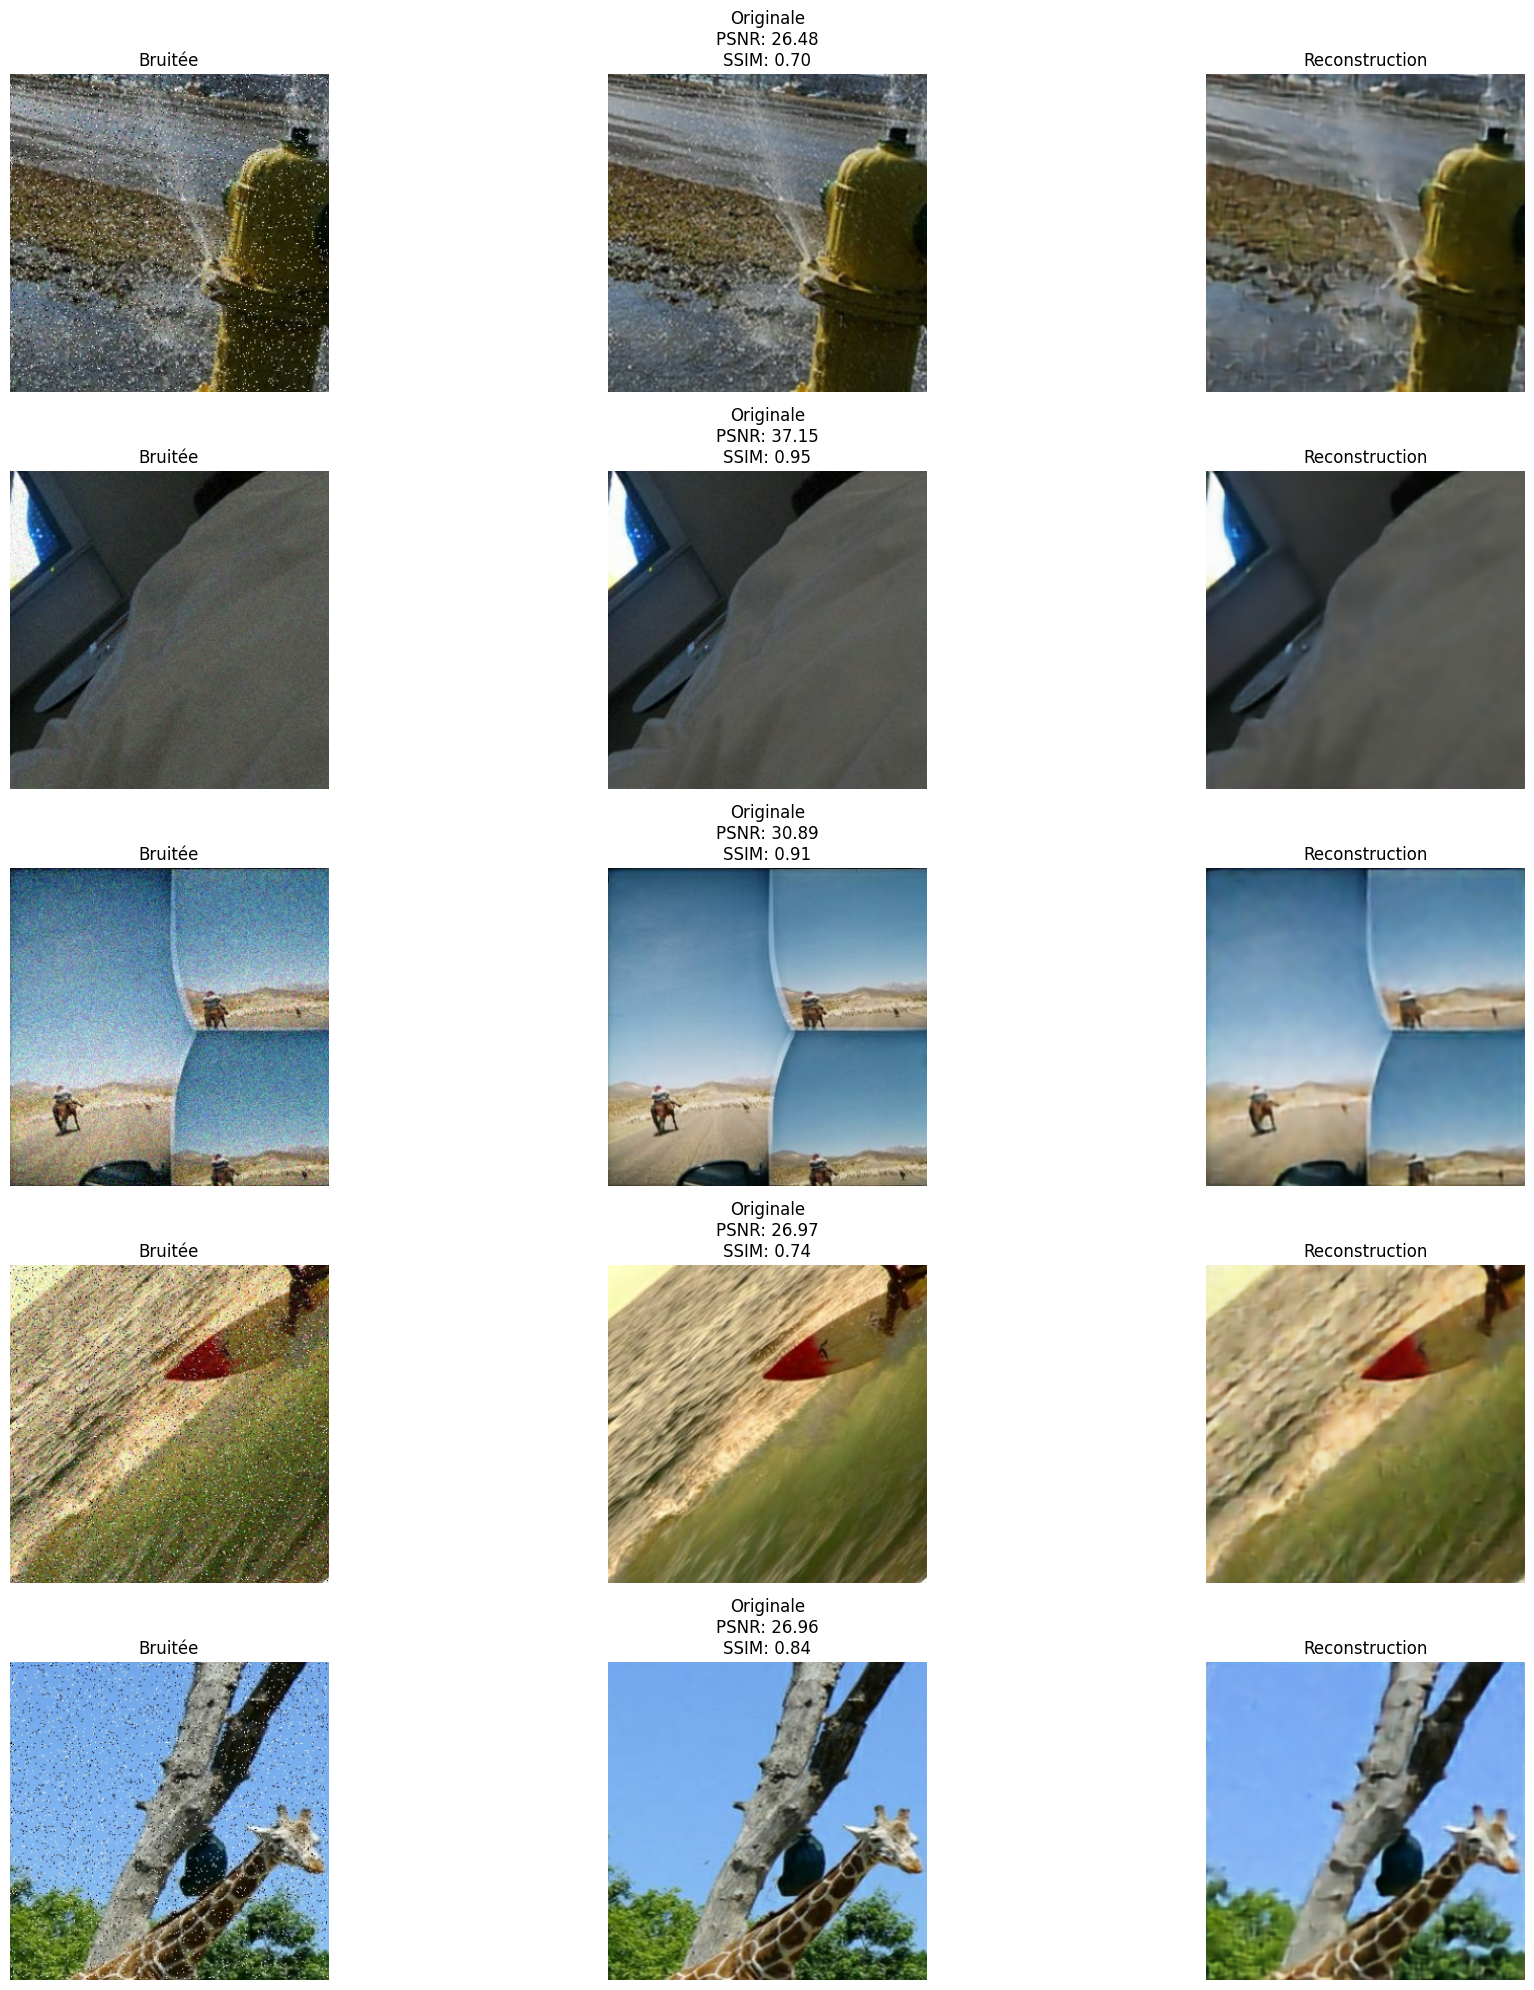

In [18]:
for noisy_images, original_images in val_dataset.take(1):  
    noisy_images_np = noisy_images.numpy()  
    original_images_np = original_images.numpy()  
    reconstructions = dae.predict(noisy_images)  

display_original_daeoutput_and_metrics(original_images_np[:5], noisy_images_np[:5], reconstructions[:5])

### 5.2. Evaluation sur les données réelles
#### Chargement des données

In [ ]:
def load_data_into_dataframe(path):
    filenames = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    df = pd.DataFrame({'filename': filenames})
    return df

df = load_data_into_dataframe(test_folder)

#### Analyse des données réelles
**Taille des images**

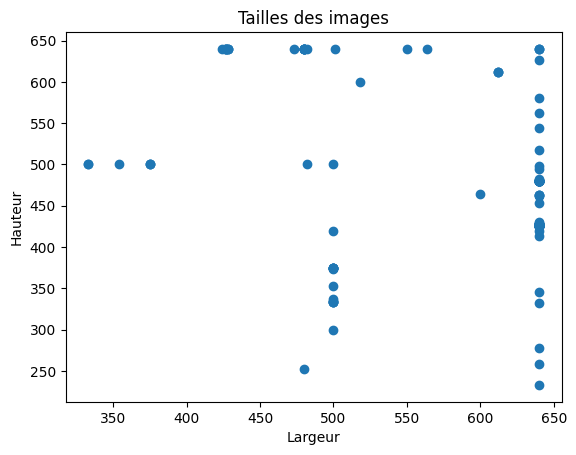

In [ ]:
def plot_image_sizes(df):
    sizes = [Image.open(f).size for f in df['filename']]
    widths, heights = zip(*sizes)
    
    plt.scatter(widths, heights)
    plt.xlabel('Largeur')
    plt.ylabel('Hauteur')
    plt.title('Tailles des images')
    plt.show()

plot_image_sizes(df)

**Types de couleurs**

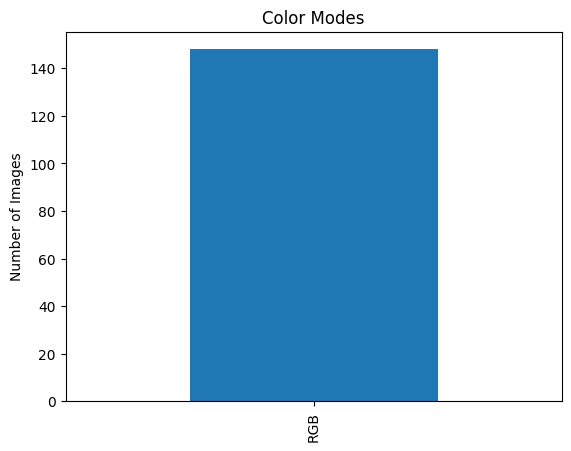

In [ ]:
def plot_color_modes(df):
    color_modes = [Image.open(f).mode for f in df['filename']]
    mode_counts = pd.Series(color_modes).value_counts()

    mode_counts.plot(kind='bar')
    plt.title('Color Modes')
    plt.ylabel('Number of Images')
    plt.show()

plot_color_modes(df)

**Chargement des données réelles et pré-processing**

In [14]:
test_dataset = load_and_normalize_from_directory('./OneDrive_2022-09-22/Dataset Livrable 2/Dataset/')

Found 148 files belonging to 1 classes.


**Comparaison des images originales et des sorties du DAE**

2/2 [==============================] - 0s 419ms/step


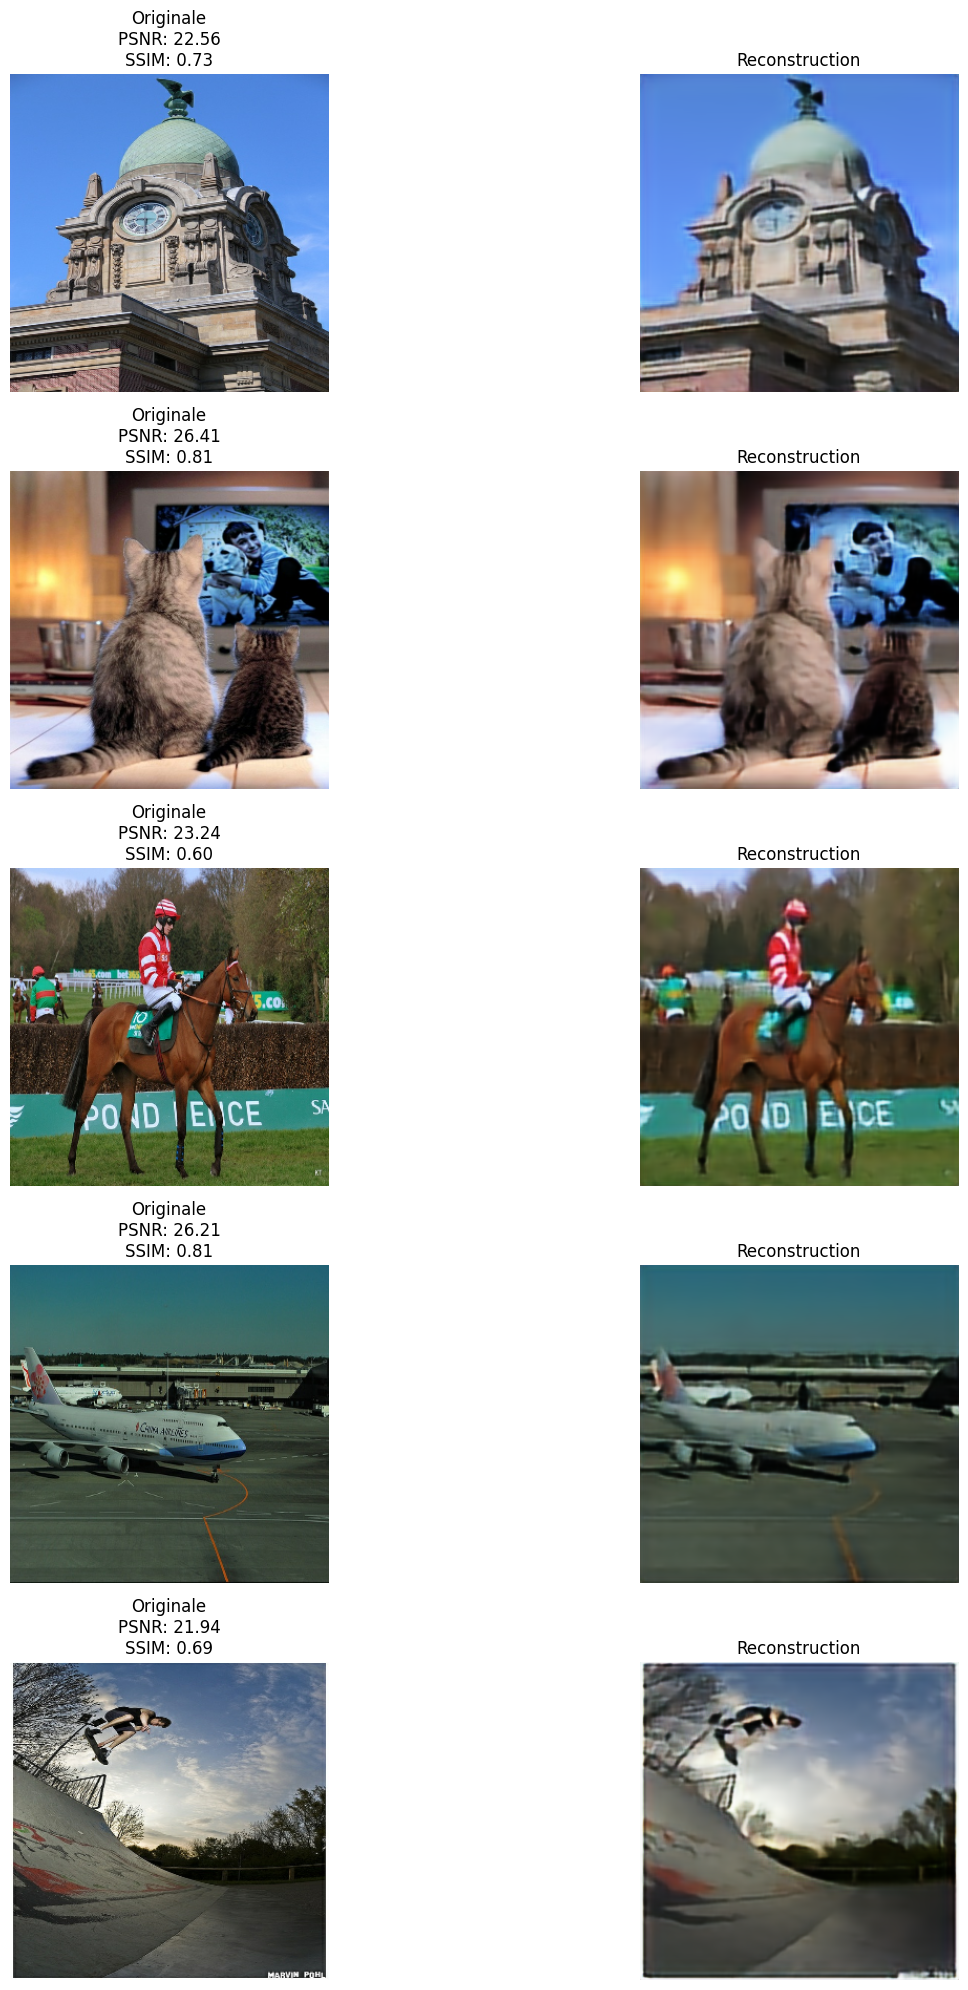

In [20]:
# Extraire un batch d'images du test_dataset
for images in test_dataset.take(1):  # Prendre un seul batch
    originals = images.numpy()  # Convertir les tensors en numpy arrays
    reconstructions = dae.predict(images)  # Obtenir les reconstructions du DAE

# Afficher quelques images originales et leurs reconstructions
display_original_daeoutput_and_metrics(originals[:5], None, reconstructions[:5])